<a href="https://colab.research.google.com/github/duttapratikcsc/LSTM_TextGeneration/blob/master/Bidrectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import sys, os
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM, Bidirectional
# from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from random import random
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

TensorFlow is already loaded. Please restart the runtime to change versions.


# Get List of Words from Corpus 

In [0]:
def get_Word(fp):
    word = []
    raw_text = open(fp).read().lower()
    raw_text = raw_text.split("\n")
    for row in raw_text:
        temp = row.split(" ")
        for i in range(len(temp)):
            word.append(temp[i])
    word.append("\n")
    print("Length of total word_list:-", len(word))
    return(word)

In [3]:
filename = 'class_3_p.csv'
seq = 3
total_words = get_Word(filename)

Length of total word_list:- 30874


Get Initial n-grams as well as last word for text generation

In [0]:
def get_initial_last_Word(fp, seq_no):
    initial_word = []
    last_word = []

    raw_text = open(fp).readlines()
    for row in raw_text:
        temp= row.split(" ")
        temp_word = ""
        for index in range(0, seq_no):
            temp_word += temp[0+index]+" "
        initial_word.append(temp_word.rstrip(" "))
        last_word.append(temp[-1].replace("\n",""))
    
    dami = list(set(initial_word))
    dx = [x.split(" ") for x in dami]
    return(dx, list(set(last_word)))

# Generate Word to Integer and Vice-versa for Embedding

In [0]:
#First create a set of all of the distinct words,
# then creating a map of each word to a unique integer.
def get_Word_dict(word_list):
    uniq_word = sorted(list(set(word_list)))
    uniqword_to_int = dict((c, i) for i, c in enumerate(uniq_word))
    print("Total no. Words:- ", len(word_list))
    print("Total no. of unique words:- ", len(uniq_word))
    return(uniqword_to_int)

def get_int_to_word(word_list):
    uniq_word = sorted(list(set(word_list)))
    int_to_word = dict((i, c) for i, c in enumerate(uniq_word))
    return(int_to_word)

In [74]:
word_dict = get_Word_dict(total_words)
int_to_word = get_int_to_word(total_words)
initial_word, last_word = get_initial_last_Word(filename, seq)
fileNN=open("initialWords.txt","w")
print(initial_word,file=fileNN)
fileNN.close()

Total no. Words:-  30874
Total no. of unique words:-  1011


# Pre Processing of Data
Prepare the dataset of input to output pairs encoded as integers

In [0]:
# prepare the dataset of input to output pairs encoded as integers
def Data_Preprocessing(fp, seq_no, word_dict):
    datax = []
    datay = []
    datay_word = []
    raw_text = open(fp).read().lower()
    raw_text = raw_text.split("\n")
    fdatax = open('data_input.csv', "w")
    fdatax_2 = open('data_input_string.csv', "w")
    for row in raw_text:
        temp = (row +" \n").split(" ")
        for i in range(len(temp)-seq_no):
            temp_word = str(temp[i])
            temp_word_int = str(word_dict[temp[i]])
            for index in range(1, seq_no+1):
                temp_word += ","+str(temp[i+index])
                temp_word_int += ","+str(word_dict[temp[i+index]])
            print(temp_word,file=fdatax_2)
            print(temp_word_int,file=fdatax)
    fdatax.close()
    fdatax_2.close()
    names = [str(i) for i in range(seq_no+1)]
    datax = pd.read_csv("data_input.csv",names=names)
    datax_2 = datax/len(word_dict)
    names = [str(i) for i in range(seq_no)]
    r = datax_2[names]
    s = datax[[str(seq_no)]] 
    return(r, s,datax)

In [9]:
datax, datay,total_dataset = Data_Preprocessing(filename, seq, word_dict)
no_patterns = len(datax)

print("datax: ", datax.shape)
print("datay: ", datay.shape)

datax:  (27600, 3)
datay:  (27600, 1)


In [10]:
X_train, X_val, y_train, y_val = train_test_split(datax,datay,test_size = 0.4)
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("Y_train: ", y_train.shape)
print("Y_val: ", y_val.shape)

X_train:  (16560, 3)
X_val:  (11040, 3)
Y_train:  (16560, 1)
Y_val:  (11040, 1)


Generate Caterogical One-hot Encodding for Output Layer

In [0]:
def create_categorical(y, total_no_words):
    categorical_data = np.zeros((len(y), total_no_words))
    print(len(y))
    for row in range(len(y)):
        temp = y[row]
        categorical_data[row][temp] = 1
    print(categorical_data)
    return(categorical_data) 

In [29]:
X = np.reshape(X_train.to_numpy(), (len(X_train), seq, 1))
y = create_categorical(y_train.to_numpy(), len(set(total_words)))

16560
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
X_val = np.reshape(X_val.to_numpy(), (len(X_val), seq, 1))
y_val = create_categorical(y_val.to_numpy(), len(set(total_words)))

11040
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [28]:
print(y.shape)

(16560, 1011)



### Plot Generation of Validation vs Train

In [0]:
def plot_history(histories, key='categorical_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')
  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()
  plt.xlim([0,max(history.epoch)])

# Bidirectional LSTM Model Creation

In [0]:
def createModel(X,y):
  model = Sequential()
  model.add(Bidirectional(LSTM(512, return_sequences=True),input_shape=(X.shape[1], X.shape[2])))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(512)))
  model.add(Dropout(0.2))
  model.add(Dense(y.shape[1], activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy', 'categorical_crossentropy'])
  model.summary()
  return model

Create Bidirectional Model

In [31]:
model = createModel(X, y)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 3, 1024)           2105344   
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 1024)              6295552   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1011)              1036275   
Total params: 9,437,171
Trainable params: 9,437,171
Non-trainable params: 0
_________________________________________________________

## Save checkpoints during training
### Checkpoint callback usage

In [0]:
checkpoint_folder = "training_1"
checkpoint_path = checkpoint_folder+"/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
try:
  os.mkdir(checkpoint_folder)
except:
  pass

In [0]:
!ls {checkpoint_folder}

### Create a callback that saves the model's weights

In [0]:
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Fit the model

In [42]:
histories = model.fit(X, y, epochs=50, batch_size=128, validation_data=(X_val, y_val),callbacks=[cp_callback])

Train on 16560 samples, validate on 11040 samples
Epoch 1/50





16560/16560 [==============================] - 122s 7ms/step - loss: 4.3228 - acc: 0.1123 - categorical_crossentropy: 4.3228 - val_loss: 3.7100 - val_acc: 0.3329 - val_categorical_crossentropy: 3.7100

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/50
16560/16560 [==============================] - 117s 7ms/step - loss: 3.2631 - acc: 0.3719 - categorical_crossentropy: 3.2631 - val_loss: 2.9749 - val_acc: 0.4262 - val_categorical_crossentropy: 2.9749

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/50
16560/16560 [==============================] - 118s 7ms/step - loss: 2.7430 - acc: 0.4546 - categorical_crossentropy: 2.7430 - val_loss: 2.7518 - val_acc: 0.4716 - val_categorical_crossentropy: 2.7518

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/50
16560/16560 [==============================] - 118s 7ms/step - loss: 2.5082 - acc: 0.4916 - categorical_crossentropy: 2.5082 - val_loss: 2.6321 - val_a

In [0]:
model.save('my_model.h5')

In [0]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 512)            1052672   
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1011)              518643    
Total params: 3,670,515
Trainable params: 3,670,515
Non-trainable params: 0
_

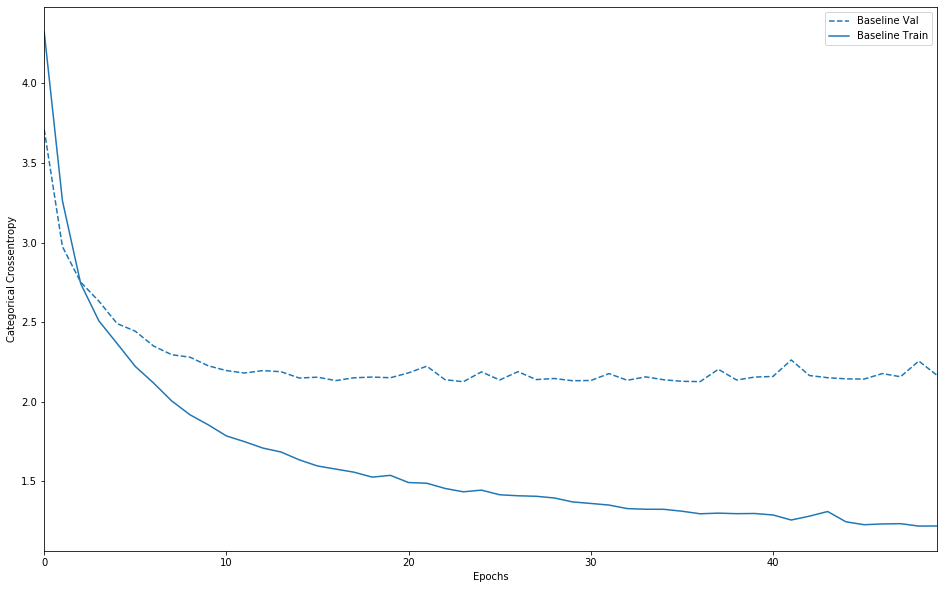

In [44]:
plot_history([('baseline', histories)])

In [0]:
def generateTweet(fileN):
  start = np.random.randint(0, len(initial_word)-1)
  seed_text = initial_word[start]
  #print(seed_text)
  seed = [word_dict[word] for word in seed_text]
  generatedTextList = ' '.join([str(elem) for elem in seed_text])
  # print('generatedTextList 1:',generatedTextList) 
  flag = True
  count=0

  while (flag):
    x = np.reshape(seed, (1, len(seed), 1))
    x = x / float(len(set(total_words)))
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_word[index]
    generatedTextList += ' '+result
    seq_in = [int_to_word[value] for value in seed]
    seed.append(index)
    seed = seed[1:len(seed)]
    if result == "\n" or count==15:
        flag = False
    count+=1

  finalText = generatedTextList.replace('\n','')
  # print('generatedTextList 2 :',finalText) 
  finalText = finalText.replace('\s','')
  # print('generatedTextList 3:',finalText) 
  return finalText

In [0]:
initial_word, last_word = get_initial_last_Word(filename, seq)
initial_word

In [75]:
fileN=open("generatedText_bi_LSTM.txt","w")
for i in range(500):
  finalText = generateTweet(fileN)
  print(i,",",finalText, file = fileN)
  print('[{0}] {1}'.format(i,finalText))
fileN.close()

[0] from ajc flyover connector has slowed down the traffic towards point 
[1] one goods vehicle pressure 
[2] sudden break down of a vehicle on maa flyover near no bridge has slowed down the traffic towards point
[3] light pressure on ajc bose flyover near victoria south gate has slowed down the traffic towards point 
[4] removed the broken down vehicle on broken road near tea board has slowed down the traffic towards point 
[5] cbuses of picnic connector near gobinda pukur east has slowed down the traffic towards point 
[6] jl nehru road near kyd gardens flyover has slowed down the traffic towards point 
[7] the broken down vehicle on broken road near tea board has slowed down the traffic towards point 
[8] maa flyover west bound going 
[9] due to removal from has slowed down the traffic towards point 
[10] traffic is obstructed the traffic towards point 
[11] due to dispersal of 
[12] broken down trailer on broken road near tea board has slowed down the traffic towards point 
[13] ci

In [0]:
import numpy as np
from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=2)
kf.get_n_splits(X)